In [2]:
%pylab inline
import gc
import galsim
import numpy as np
%load_ext autoreload
%autoreload 2
import fpfsBase
import astropy.io.fits as pyfits

Populating the interactive namespace from numpy and matplotlib


In [3]:
cd wrkDir/FPFS2/sim

/lustre/work/xiangchong.li/work/FPFS2/sim


In [ ]:
# PSF preparation
ifield=1
psfPre='psfPre'
# Basic parameters
ngrid       =   64
nrot        =   4
nx          =   nrot 
ny          =   1
ndata       =   nx*ny
scale       =   0.168
bigfft      =   galsim.GSParams(maximum_fft_size=10240)
flux_scaling=   2.587

# Get the psf and nosie information 
psfFname    =   os.path.join(psfPre,'psf%04d.fits'%(ifield))
psfImg      =   galsim.fits.read(psfFname)
noiseHead   =   pyfits.getheader(psfFname)
psfInt      =   galsim.InterpolatedImage(psfImg,scale=scale,flux = 1.) 
# Get the shear information
g1          =   noiseHead['g1']
g2          =   noiseHead['g2']
fwhm        =   noiseHead['fwhm'] 
variance    =   noiseHead['var']
rescale     =   noiseHead['rescale']
ud          =   galsim.UniformDeviate(ifield*10000+1)
np.random.seed(ifield*10000+1)

In [ ]:
# setup the galaxy image and the noise image
gal_image   =   galsim.ImageF(nx*ngrid,ny*ngrid,scale=scale)
gal_image.setOrigin(0,0)
var_image   =   galsim.ImageF(nx*ngrid,ny*ngrid,scale=scale)
var_image.setOrigin(0,0)
data_rows   =   []

# Get the  galaxy generator      
# Load data
catName     =   'real_galaxy_catalog_23.5.fits'
directory   =   '/home/xiangchong/work/gw_ipmu/work/galsim_train/COSMOS_23.5_training_sample/'
cosmos_cat  =   galsim.COSMOSCatalog(catName, dir=directory)
# index
index_use   =   cosmos_cat.orig_index
# parametric catalog
param_cat   =   cosmos_cat.param_cat[index_use]
index       =   ifield%81400
record      =   param_cat[index]
# prepare the galaxies
gal0        =   cosmos_cat.makeGalaxy(gal_type='parametric',index=index,gsparams=bigfft)
gal0        *=  flux_scaling
use_bulgefit=   record['use_bulgefit']
if use_bulgefit:
    bparams = record['bulgefit']
    gal_q   = bparams[3]
    gal_beta= bparams[7]*galsim.radians
    hlr     = record['hlr'][2]
    bulge_flux= record['flux'][1]
    disk_flux= record['flux'][2]
    flux    = (bulge_flux+disk_flux)*flux_scaling
else:
    sparams =   record['sersicfit']
    gal_q   =   sparams[3]
    gal_beta=   sparams[7]*galsim.radians
    hlr     =   record['hlr'][0]
    flux    =   record['flux'][0]*flux_scaling
# Get the SNR
fluxRadius  =   record['flux_radius']
snr         =   flux/fluxRadius/np.sqrt(np.pi)/np.sqrt(variance)
npoints     =   ud()*50+50
gal_not0    =   galsim.RandomWalk(half_light_radius=0.4,npoints=npoints,flux=flux)
gal_not0    =   gal_not0.shear(q=gal_q,beta=gal_beta)
for i in range(nrot):
    # Prepare the subimage
    ix      =   int(i%nx)
    iy      =   int(i/nx)
    b       =   galsim.BoundsI(ix*ngrid, (ix+1)*ngrid-1,iy*ngrid,(iy+1)*ngrid-1)
    sub_gal_image = gal_image[b]
    if i%nrot==0:
        # Get the galaxy image
        notRat  =   0.1#ud()*0.1
        gal     =   gal0*(1.-notRat)+gal_not0*notRat
        # Dilate the galaxy
        dilatS  =   1.+(ud()-0.5)*0.1
        gal     =   gal.dilate(dilatS)
        # Rotate the galaxy
        ang     =   ud()*2.*np.pi * galsim.radians
        gal     =   gal.rotate(ang)
        final   =   gal.shear(g1=g1,g2=g2)
    else:
        gal     =   gal.rotate(1./nrot*np.pi*galsim.radians)
        final   =   gal.shear(g1=g1,g2=g2)
    # Shear the galaxy
    final     =   galsim.Convolve([psfInt,final],gsparams=bigfft)
    # Draw the galaxy image
    final.drawImage(sub_gal_image,method='no_pixel')

In [ ]:
ngrid=64
xy1d=np.fft.fftshift(np.fft.fftfreq(ngrid,d=1./ngrid))
xfun,yfun=  np.meshgrid(xy1d,xy1d)

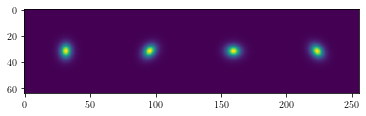

In [6]:
plt.imshow(gal_image.array)

In [7]:
psfData=np.pad(psfImg.array,(11,10))
print(psfData.shape)
fpTask=fpfsBase.fpfsTask(psfData)

(64, 64)


In [8]:
%reload_ext imgutil
import imgutil
galPow=imgutil.getFouPow(psfData)
imgutil.fitNoiPow(ngrid,galPow,np.ones((1,ngrid,ngrid)),26)

array([[5.00724823e-07, 5.00724823e-07, 5.00724823e-07, ...,
        5.00724823e-07, 5.00724823e-07, 5.00724823e-07],
       [5.00724823e-07, 5.00724823e-07, 5.00724823e-07, ...,
        5.00724823e-07, 5.00724823e-07, 5.00724823e-07],
       [5.00724823e-07, 5.00724823e-07, 5.00724823e-07, ...,
        5.00724823e-07, 5.00724823e-07, 5.00724823e-07],
       ...,
       [5.00724823e-07, 5.00724823e-07, 5.00724823e-07, ...,
        5.00724823e-07, 5.00724823e-07, 5.00724823e-07],
       [5.00724823e-07, 5.00724823e-07, 5.00724823e-07, ...,
        5.00724823e-07, 5.00724823e-07, 5.00724823e-07],
       [5.00724823e-07, 5.00724823e-07, 5.00724823e-07, ...,
        5.00724823e-07, 5.00724823e-07, 5.00724823e-07]])

In [9]:
print(g1,g2)
mm1=fpTask.measure(gal_image.array[:,0*ngrid:1*ngrid])
mm2=fpTask.measure(gal_image.array[:,1*ngrid:2*ngrid])
mm3=fpTask.measure(gal_image.array[:,2*ngrid:3*ngrid])
mm4=fpTask.measure(gal_image.array[:,3*ngrid:4*ngrid])
print(mm1)
print(mm2)

-0.00497867971784556 0.01321946960652948
(68711.06693071, 8656.55982558, -126.24801478, 5217.81797176)
(68922.91475806, -264.68181282, 7876.84990695, 5085.78190523)


In [15]:
ee=fpfsBase.fpfsM2E(np.vstack([mm1,mm2,mm3,mm4]))
print(-np.sum(ee['fpfs_e1'])/np.sum(ee['fpfs_RE'])-g1)
print(-np.sum(ee['fpfs_e2'])/np.sum(ee['fpfs_RE'])-g2)

8.489338647480263e-07
-1.2397739834191235e-06


# Speed Test

In [11]:
def test_speed():
    fpTask=fpfsBase.fpfsTask(psfData)
    for i in range(10000):
        fpTask.measure(gal_image.array[:,0*ngrid:1*ngrid])
    return

In [108]:
# old code
%time test_speed()

CPU times: user 13.4 s, sys: 10 ms, total: 13.4 s
Wall time: 13.4 s


In [139]:
# new code
%time test_speed()

CPU times: user 4.38 s, sys: 3.38 ms, total: 4.39 s
Wall time: 4.39 s


In [12]:
# new code 2
%time test_speed()

CPU times: user 2.27 s, sys: 0 ns, total: 2.27 s
Wall time: 2.28 s


## Batch run

In [4]:
ngrid=64
nx=100;ny=100
ngal=nx*ny
scale=0.168
beta=0.75

16


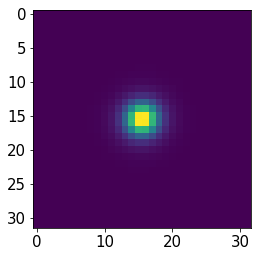

In [20]:
C=1000.
psfFWHM=0.60
tog=True
if tog:
    rcut=max(min(int(psfFWHM/scale*6+0.5),15),16)
    beg=ngrid//2-rcut
    end=beg+2*rcut
else:
    hsmCat=pyfits.getdata('galaxy_basic_psf%d/hsm-0-g1-2222.fits' %(psfFWHM*100))
    rcutArray=np.maximum(np.minimum(np.int_(hsmCat['regauss_detR']*5),15),11)
    plt.hist(rcutArray,bins=7,range=(10,16))
print(rcut)
# Initialize the fpfsTask
psfInt  =   galsim.Moffat(beta=3.5,fwhm=psfFWHM,trunc=psfFWHM*4.)
psfInt  =   psfInt.shear(e1=0.02,e2=-0.02)
psfImg  =   psfInt.drawImage(nx=64,ny=64,scale=scale)
if tog:
    psfData =   psfImg.array[beg:end,beg:end]
    plt.imshow(psfData)
    fpTask=fpfsBase.fpfsTask(psfData,beta=beta)
# read galaxy image
galImgAll1=pyfits.getdata('galaxy_basic_psf%d/image-0-g1-2222.fits' %(psfFWHM*100))
galImgAll2=pyfits.getdata('galaxy_basic_psf%d/image-0-g1-0000.fits' %(psfFWHM*100))

In [21]:
def main(galImgAll):
    imgList=[galImgAll[i//nx*ngrid+beg:i//nx*ngrid+end,i%nx*ngrid+beg:i%nx*ngrid+end] for i in range(ngal)]
    a=fpTask.measure(imgList)
    print(np.median(a['fpfs_M00']))
    b=fpfsBase.fpfsM2E(a,C)
    out=-np.average(b['fpfs_e1'])/np.average(b['fpfs_RE'])
    del imgList,a,b
    gc.collect()
    return out

def main2(galImgAll):
    bAll=[]
    for rcut in range(11,16):
        beg=ngrid//2-rcut
        end=beg+2*rcut
        inds=np.where(rcutArray==rcut)[0]
        fpTask=fpfsBase.fpfsTask(psfImg.array[beg:end,beg:end],beta=beta)
        imgList=[galImgAll[i//nx*ngrid+beg:i//nx*ngrid+end,i%nx*ngrid+beg:i%nx*ngrid+end] for i in inds]
        a=fpTask.measure(imgList)
        print(len(a))
        b=fpfsBase.fpfsM2E(a,C)
        bAll.append(b)
        del imgList,a,b
        gc.collect()
    bAll=np.vstack(bAll)
    out=-np.average(bAll['fpfs_e1'])/np.average(bAll['fpfs_RE'])
    return out,bAll

In [22]:
%%time
if tog:
    out1=main(galImgAll1)
    out2=main(galImgAll2)
else:
    out1,bAll=main2(galImgAll1)
    out2,bAll=main2(galImgAll2)
gc.collect()

646.7804491052035
647.6628078122579
CPU times: user 5.15 s, sys: 118 ms, total: 5.27 s
Wall time: 5.29 s


0

In [23]:
(out1-out2)/0.04-1

0.00026469197806000544